In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request
from matplotlib.font_manager import fontManager
import matplotlib
import pandas as pd
import properscoring as ps
from scipy.stats import t
import seaborn as sns

In [140]:

model_predictions = np.load("results/pred_20251218_121419_best_val_post_test.npy")
ground_truths = np.load("results/truths.npy")
model_samples = np.load("results/samples_20251218_121419_best_val_post_test.npy")
baseline_predictions = np.load("urbanev/TimeXer_predictions.npy")
baseline_predictions = np.concatenate([baseline_predictions[:, :, -1:], baseline_predictions], axis=-1)[:, :, :-1]
baseline_predictions = baseline_predictions[:model_predictions.shape[0]]
model_predictions = model_predictions[:baseline_predictions.shape[0]]
model_samples = model_samples[:baseline_predictions.shape[0]]


In [141]:
print(f"model_predictions shape:{model_predictions.shape},\n model_samples shape:{model_samples.shape},\n ground_truths shape:{ground_truths.shape}") 

model_predictions shape:(412, 12, 275),
 model_samples shape:(412, 20, 12, 275),
 ground_truths shape:(412, 12, 275)


In [142]:
# 定义数据形状
B = 412  # 批量大小 (数据点数量)
L = 12   # 预测长度
N = 275  # 节点数
S = 40   # 样本数 (NUM_SAMPLES)

In [143]:
import numpy as np

def _validate_shapes(y_true, y_pred_samples):
    y_true = np.asarray(y_true)
    y_pred_samples = np.asarray(y_pred_samples)

    if (y_true.ndim == 3 and y_pred_samples.ndim == 4):
        # y_true: (B, L, N), y_pred_samples: (B, S, L, N)
        assert y_pred_samples.shape[0] == y_true.shape[0]
        assert y_pred_samples.shape[2] == y_true.shape[1]
        assert y_pred_samples.shape[3] == y_true.shape[2]
        sample_axis = 1
        y_true_expanded = np.expand_dims(y_true, axis=1)  # (B,1,L,N)
    elif (y_true.ndim == 1 and y_pred_samples.ndim == 2):
        # y_true: (P,), y_pred_samples: (P, S)
        assert y_pred_samples.shape[0] == y_true.shape[0]
        sample_axis = 1
        y_true_expanded = np.expand_dims(y_true, axis=1)  # (P,1)
    else:
        raise ValueError(f"Shape mismatch: y_true {y_true.shape}, y_pred_samples {y_pred_samples.shape}")

    if np.any(~np.isfinite(y_true_expanded)):
        raise ValueError("y_true contains NaN/Inf.")
    if np.any(~np.isfinite(y_pred_samples)):
        raise ValueError("y_pred_samples contains NaN/Inf.")

    return y_true, y_pred_samples, y_true_expanded, sample_axis


def calculate_pit_randomized(y_true, y_pred_samples, seed=0):
    """
    Randomized PIT:
        PIT = F_hat(y-) + U * (F_hat(y) - F_hat(y-))
    where:
        F_hat(y)   = P(sample <= y)
        F_hat(y-)  = P(sample <  y)
        U ~ Uniform(0,1)
    This avoids bias when there are ties / discrete predictive distributions.
    """
    rng = np.random.default_rng(seed)
    _, y_pred_samples, y_true_expanded, sample_axis = _validate_shapes(y_true, y_pred_samples)

    lt = np.mean(y_pred_samples <  y_true_expanded, axis=sample_axis)
    le = np.mean(y_pred_samples <= y_true_expanded, axis=sample_axis)
    u = rng.random(size=lt.shape)

    pit = lt + u * (le - lt)  # randomized within the tie mass
    pit = np.clip(pit, 0.0, 1.0)
    return pit.reshape(-1)


def pit_uniform_confidence_band(n, bins=10, alpha=0.05):
    """
    直方图每个 bin 的理论期望频率为 1/bins。
    给出每个 bin 频率的 Binomial( n, 1/bins ) 的近似 95% CI（正态近似）。
    若你希望更严谨，可换 Clopper-Pearson；但该 band 在论文里通常够用。
    """
    p = 1.0 / bins
    # 频率的标准差：sqrt(p(1-p)/n)
    se = np.sqrt(p * (1 - p) / n)
    z = 1.959963984540054  # ~N(0,1) 97.5%
    lo = p - z * se
    hi = p + z * se
    return max(lo, 0.0), min(hi, 1.0)


def ks_test_uniform(pit_values):
    """
    KS test for Uniform(0,1). 需要 scipy；若环境没有 scipy，可自行实现近似或跳过。
    """
    try:
        from scipy import stats
        res = stats.kstest(pit_values, 'uniform')
        return float(res.statistic), float(res.pvalue)
    except Exception:
        return None, None


In [144]:
def wilson_ci(k, n, alpha=0.05):
    """
    Wilson score interval for binomial proportion.
    k: successes, n: trials
    returns (lo, hi)
    """
    if n <= 0:
        return (np.nan, np.nan)
    z = 1.959963984540054  # 95%
    phat = k / n
    denom = 1 + z**2 / n
    center = (phat + z**2 / (2*n)) / denom
    half = (z * np.sqrt((phat*(1-phat) + z**2/(4*n)) / n)) / denom
    return (max(0.0, center - half), min(1.0, center + half))


def calculate_quantile_reliability(y_true, y_pred_samples, quantiles=None):
    """
    Returns:
      q: (Q,)
      obs: (Q,)  observed frequencies P(y_true <= Q_hat(q))
      n_points: int  total data points aggregated
      ci: (Q,2) Wilson 95% CI for obs
      ece: float mean |obs - q|
      mce: float max  |obs - q|
    """
    if quantiles is None:
        quantiles = np.linspace(0.1, 1.0, 10)
    quantiles = np.asarray(quantiles, dtype=float)
    if np.any((quantiles <= 0) | (quantiles > 1)):
        raise ValueError("quantiles must be in (0,1].")

    y_true, y_pred_samples, _, sample_axis = _validate_shapes(y_true, y_pred_samples)

    # predicted quantiles: shape (Q, ...) where "..." matches y_true shape
    pred_q = np.quantile(y_pred_samples, q=quantiles, axis=sample_axis)

    # broadcast compare
    y_true_exp = np.expand_dims(y_true, axis=0)  # (1,...)  to match (Q,...)
    ok = (y_true_exp <= pred_q)                  # (Q,...)

    # aggregate over all non-Q axes
    axes = tuple(range(1, ok.ndim))
    k = np.sum(ok, axis=axes).astype(int)        # (Q,)
    n = int(np.prod(y_true.shape))               # total points aggregated
    obs = k / n

    # Wilson CI
    ci = np.array([wilson_ci(int(kk), n) for kk in k], dtype=float)  # (Q,2)

    # quantile calibration errors
    abs_err = np.abs(obs - quantiles)
    ece = float(np.mean(abs_err))
    mce = float(np.max(abs_err))

    return quantiles, obs, n, ci, ece, mce


In [145]:
import matplotlib.pyplot as plt

def plot_pit_histogram(pit, bins=10, title="PIT Histogram", show_band=True, show_ks=True):
    pit = np.asarray(pit)
    n = pit.size

    plt.figure(figsize=(6.5, 6.0))
    plt.hist(pit, bins=bins, range=(0,1), density=True, edgecolor="black", alpha=0.85)

    # uniform density reference
    plt.axhline(1.0, linestyle="--", linewidth=1.5, label="Uniform(0,1) density")

    if show_band:
        lo, hi = pit_uniform_confidence_band(n=n, bins=bins)
        # density band: frequency band * bins
        plt.axhspan(lo*bins, hi*bins, alpha=0.15, label="95% band (sampling noise)")

    txt = ""
    if show_ks:
        D, p = ks_test_uniform(pit)
        if D is not None:
            txt = f"KS: D={D:.4f}, p={p:.4g}, N={n}, bins={bins}"
            plt.gca().text(0.02, 0.98, txt, transform=plt.gca().transAxes,
                           va="top", ha="left", fontsize=10)

    plt.title(title)
    plt.xlabel("PIT value")
    plt.ylabel("Density")
    plt.xlim(0, 1)
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()


def plot_quantile_reliability(q, obs, ci, ece=None, mce=None, title="Quantile Reliability Diagram"):
    q = np.asarray(q)
    obs = np.asarray(obs)
    ci = np.asarray(ci)  # (Q,2)

    yerr_lower = obs - ci[:,0]
    yerr_upper = ci[:,1] - obs
    yerr = np.vstack([yerr_lower, yerr_upper])

    plt.figure(figsize=(6.5, 6.0))
    plt.plot([0,1], [0,1], linestyle="--", linewidth=1.5, label="Perfect calibration")
    plt.errorbar(q, obs, yerr=yerr, fmt="o-", capsize=3, label="Model")

    ann = []
    if ece is not None:
        ann.append(f"ECE={ece:.4f}")
    if mce is not None:
        ann.append(f"MCE={mce:.4f}")
    if ann:
        plt.gca().text(0.02, 0.98, ", ".join(ann), transform=plt.gca().transAxes,
                       va="top", ha="left", fontsize=10)

    plt.title(title)
    plt.xlabel("Predicted quantiles (q)")
    plt.ylabel("Observed frequency: P(y ≤ Q̂(q))")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis("square")
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()


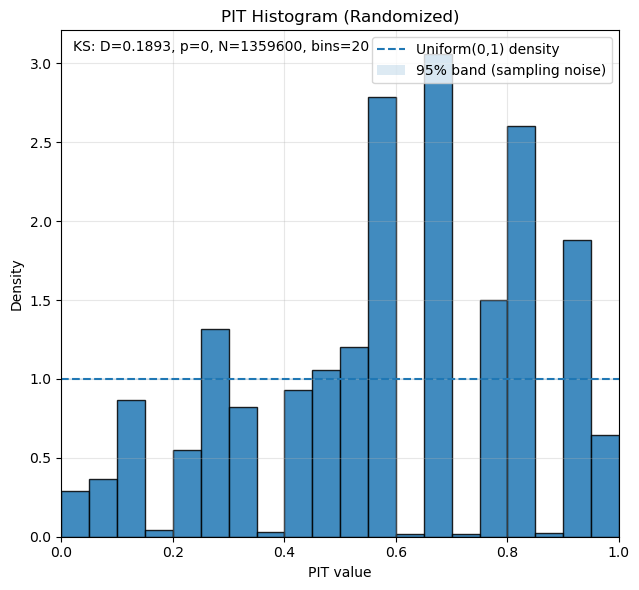

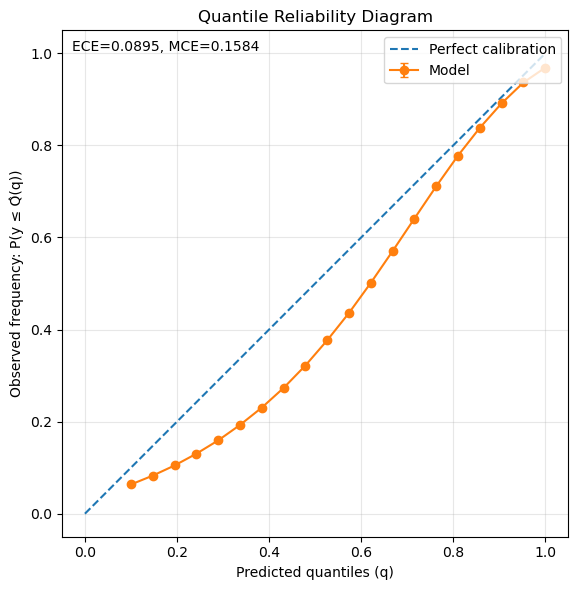

In [146]:
# 计算 randomized PIT（更严谨）
pit_values = calculate_pit_randomized(ground_truths, model_samples, seed=0)
plot_pit_histogram(pit_values, bins=20, title="PIT Histogram (Randomized)")

# 计算 quantile reliability + CI + ECE/MCE
q, obs, n_points, ci, ece, mce = calculate_quantile_reliability(
    ground_truths, model_samples,
    quantiles=np.linspace(0.1, 1.0, 20)
)
plot_quantile_reliability(q, obs, ci, ece=ece, mce=mce, title="Quantile Reliability Diagram")


Block bootstrap: n_points=1359600, n_blocks=275, ECE=0.0868, MCE=0.1563


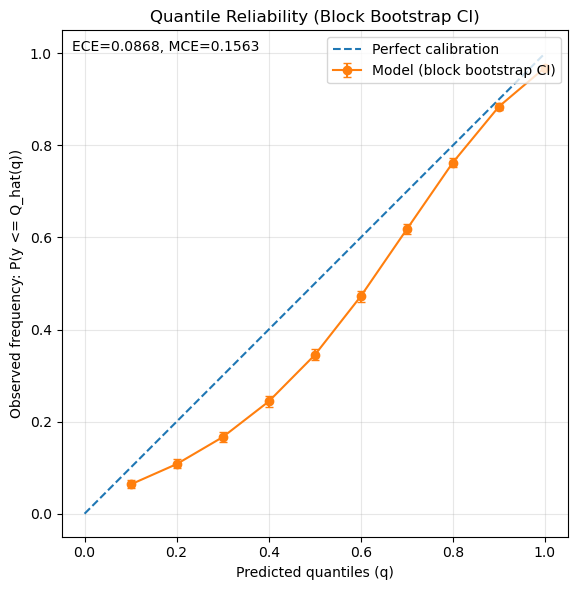

In [147]:
def _validate_shapes(y_true, y_pred_samples):
    y_true = np.asarray(y_true)
    y_pred_samples = np.asarray(y_pred_samples)

    if (y_true.ndim == 3 and y_pred_samples.ndim == 4):
        # y_true: (B, L, N), y_pred_samples: (B, S, L, N)
        if not (y_pred_samples.shape[0] == y_true.shape[0] and
                y_pred_samples.shape[2] == y_true.shape[1] and
                y_pred_samples.shape[3] == y_true.shape[2]):
            raise ValueError(f"Shape mismatch: y_true {y_true.shape}, y_pred_samples {y_pred_samples.shape}")
        sample_axis = 1
    elif (y_true.ndim == 1 and y_pred_samples.ndim == 2):
        # y_true: (P,), y_pred_samples: (P, S)
        if y_pred_samples.shape[0] != y_true.shape[0]:
            raise ValueError(f"Shape mismatch: y_true {y_true.shape}, y_pred_samples {y_pred_samples.shape}")
        sample_axis = 1
    else:
        raise ValueError(f"Shape mismatch: y_true {y_true.shape}, y_pred_samples {y_pred_samples.shape}")

    if np.any(~np.isfinite(y_true)):
        raise ValueError("y_true contains NaN/Inf.")
    if np.any(~np.isfinite(y_pred_samples)):
        raise ValueError("y_pred_samples contains NaN/Inf.")

    return y_true, y_pred_samples, sample_axis


def quantile_reliability_block_bootstrap(
    y_true,
    y_pred_samples,
    block_ids,
    quantiles=None,
    n_boot=1000,
    ci=0.95,
    seed=0,
):
    """
    Quantile reliability with block bootstrap CI.

    Inputs:
      y_true:          (B,L,N) or (P,)
      y_pred_samples:  (B,S,L,N) or (P,S)
      block_ids:       same shape as y_true, indicates block membership of each datapoint.
                       e.g., block by zone, by date, or by (date,zone).
      quantiles:       array of q values in (0,1], default 0.1..1.0 step 0.1
      n_boot:          bootstrap replicates (500-2000 typical)
      ci:              confidence level, e.g., 0.95
      seed:            RNG seed

    Returns dict:
      q:        (Q,)
      obs:      (Q,) point estimate on full sample
      ci_low:   (Q,)
      ci_high:  (Q,)
      ece:      float  mean |obs - q|
      mce:      float  max  |obs - q|
      n_points: int total datapoints
      n_blocks: int number of blocks
    """
    if quantiles is None:
        quantiles = np.linspace(0.1, 1.0, 10)
    q = np.asarray(quantiles, dtype=float)
    if np.any((q <= 0) | (q > 1)):
        raise ValueError("quantiles must be in (0,1].")

    y_true, y_pred_samples, sample_axis = _validate_shapes(y_true, y_pred_samples)
    block_ids = np.asarray(block_ids)

    if block_ids.shape != y_true.shape:
        raise ValueError(f"block_ids must have same shape as y_true. got {block_ids.shape} vs {y_true.shape}")

    # 1) 先算每个点的预测分位数阈值 Q_hat(q)
    pred_q = np.quantile(y_pred_samples, q=q, axis=sample_axis)  # (Q, ...) where ... matches y_true

    # 2) flatten 成 P 个点
    y_flat = y_true.reshape(-1)
    b_flat = block_ids.reshape(-1)

    # 将 block 映射到 0..K-1
    uniq, inv = np.unique(b_flat, return_inverse=True)
    K = uniq.size
    P = y_flat.size

    # 每个 block 的样本数
    block_n = np.bincount(inv, minlength=K).astype(np.int64)

    # 3) 对每个 q，计算每个 block 内 "success" 次数：I(y <= Q_hat(q))
    #    注意 pred_q 形状为 (Q, ...)，flatten 后是 (Q, P)
    pred_q_flat = pred_q.reshape(q.size, -1)

    block_succ = np.zeros((q.size, K), dtype=np.float64)
    for i in range(q.size):
        succ_i = (y_flat <= pred_q_flat[i]).astype(np.float64)
        block_succ[i] = np.bincount(inv, weights=succ_i, minlength=K)

    # 4) 全样本点估计
    total_n = block_n.sum()
    obs = block_succ.sum(axis=1) / total_n  # (Q,)

    # 5) block bootstrap：重采样 blocks（而不是 points）
    rng = np.random.default_rng(seed)
    boot_obs = np.zeros((n_boot, q.size), dtype=np.float64)

    for t in range(n_boot):
        sampled_blocks = rng.integers(0, K, size=K)  # sample K blocks with replacement
        mult = np.bincount(sampled_blocks, minlength=K).astype(np.float64)  # multiplicities per block

        denom = float(np.sum(block_n * mult))
        # 对每个 q：sum(block_succ[q, b] * mult[b]) / denom
        numer = block_succ @ mult  # (Q,)
        boot_obs[t] = numer / denom

    alpha = (1.0 - ci) / 2.0
    ci_low = np.quantile(boot_obs, alpha, axis=0)
    ci_high = np.quantile(boot_obs, 1.0 - alpha, axis=0)

    abs_err = np.abs(obs - q)
    ece = float(np.mean(abs_err))
    mce = float(np.max(abs_err))

    return {
        "q": q,
        "obs": obs,
        "ci_low": ci_low,
        "ci_high": ci_high,
        "ece": ece,
        "mce": mce,
        "n_points": int(P),
        "n_blocks": int(K),
        "boot_obs": boot_obs,  # 如不需要可删掉以省内存
    }

def plot_quantile_reliability_with_ci(q, obs, ci_low, ci_high, ece=None, mce=None, title="Quantile Reliability (Block Bootstrap CI)"):
    q = np.asarray(q)
    obs = np.asarray(obs)
    ci_low = np.asarray(ci_low)
    ci_high = np.asarray(ci_high)

    yerr = np.vstack([obs - ci_low, ci_high - obs])

    plt.figure(figsize=(6.5, 6.0))
    plt.plot([0,1],[0,1],'--', linewidth=1.5, label="Perfect calibration")
    plt.errorbar(q, obs, yerr=yerr, fmt="o-", capsize=3, label="Model (block bootstrap CI)")

    txt = []
    if ece is not None: txt.append(f"ECE={ece:.4f}")
    if mce is not None: txt.append(f"MCE={mce:.4f}")
    if txt:
        plt.text(0.02, 0.98, ", ".join(txt), transform=plt.gca().transAxes, va="top", ha="left")

    plt.title(title)
    plt.xlabel("Predicted quantiles (q)")
    plt.ylabel("Observed frequency: P(y <= Q_hat(q))")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.axis("square")
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper right")
    plt.tight_layout()

# 1) 构造 block_ids（建议先用最保守的 date×zone）
# zone_id: shape (N,) = [0..N-1] 或真实 zone 编号
zone_id = np.arange(N)
block_ids = np.broadcast_to(zone_id.reshape(1,1,N), (B,L,N))




# 2) 计算 block bootstrap CI
res = quantile_reliability_block_bootstrap(
    ground_truths,
    model_samples,
    block_ids=block_ids,
    quantiles=np.linspace(0.1, 1.0, 10),
    n_boot=1000,   # 先用 500/1000；论文最终可 1000-2000
    ci=0.95,
    seed=0,
)

print(f"Block bootstrap: n_points={res['n_points']}, n_blocks={res['n_blocks']}, ECE={res['ece']:.4f}, MCE={res['mce']:.4f}")

# 3) 画图（带 CI）
plot_quantile_reliability_with_ci(
    res["q"], res["obs"], res["ci_low"], res["ci_high"],
    ece=res["ece"], mce=res["mce"],
)


In [148]:
half_width = 0.5 * (res["ci_high"] - res["ci_low"])
print("max half-width:", half_width.max(), "min:", half_width.min())
print("half-widths:", np.round(half_width, 6))


max half-width: 0.012116017578699623 min: 0.0029571289349809016
half-widths: [0.008815 0.009359 0.010214 0.011587 0.012116 0.012063 0.011238 0.009792
 0.007319 0.002957]


--- 概率预测评估脚本 ---

--- 正在计算 PIT 直方图 ---
PIT 直方图已保存到: pit_histogram.png

--- 正在计算可靠性图 ---
可靠性图已保存到: reliability_diagram.png


c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  func(*args, **kwargs)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  func(*args, **kwargs)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 30452 (\N{CJK UNIFIED IDEOGRAPH-76F4}) missing from current font.
  func(*args, **kwargs)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from current font.
  func(*args, **kwargs)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from current font.
  func(*args, **kwargs)
c:\Users\ll\.conda\envs\UrbanEV\lib\site-packages\IPython\core\events.

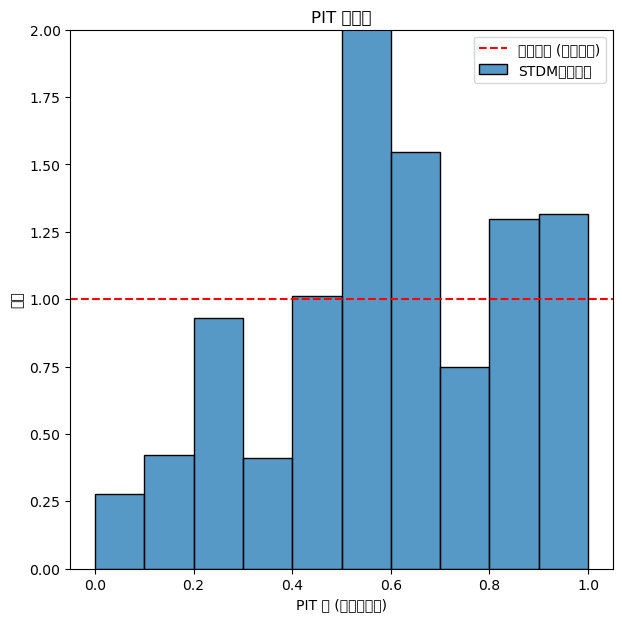

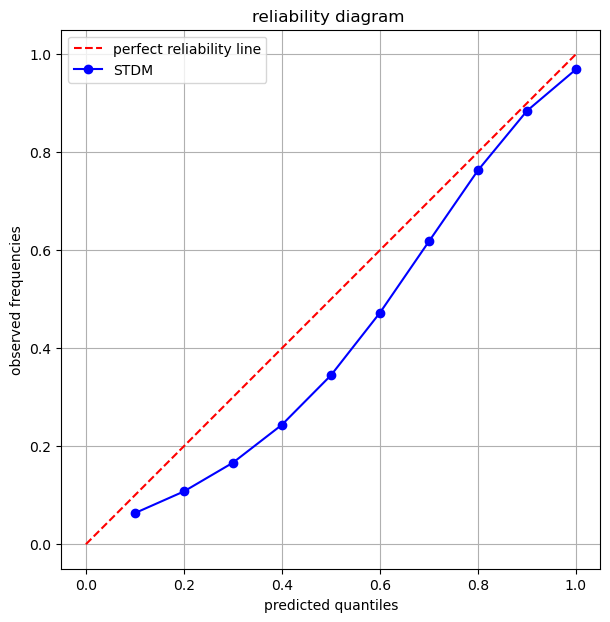

In [149]:
def calculate_pit(y_true, y_pred_samples):
    """
    计算概率积分变换 (PIT) 值。
    
    这是评估概率预测校准度的核心工具。
    它计算的是真实值 (y_true) 相对于预测样本 (y_pred_samples) 的经验分位数。
    
    参数:
    y_true (np.ndarray): 真实值数组。
                          形状: (B, L, N) 或 (num_datapoints,)
    y_pred_samples (np.ndarray): 预测样本数组。
                                  形状: (B, S, L, N) 或 (num_datapoints, S)
                                  其中 S 是样本数量。

    返回:
    np.ndarray: 一维数组，包含所有数据点的 PIT 值 (范围在 0 到 1 之间)。
                如果预测完美校准，此数组应服从均匀分布。
    """
    
    # 为了进行广播比较，我们需要将 y_true 的形状扩展为 (B, 1, L, N)
    # 以便它能和 (B, S, L, N) 的 y_pred_samples 进行比较。
    if y_true.ndim == 3 and y_pred_samples.ndim == 4:
        # 假设 y_true: (B, L, N), y_pred_samples: (B, S, L, N)
        # B = 批量大小, L = 预测长度, N = 节点数, S = 样本数
        y_true_expanded = np.expand_dims(y_true, axis=1) # 形状变为 (B, 1, L, N)
        sample_axis = 1 # 样本在 S 维度上
    elif y_true.ndim == 1 and y_pred_samples.ndim == 2:
        # 假设 y_true: (N,), y_pred_samples: (N, S)
        y_true_expanded = np.expand_dims(y_true, axis=1) # 形状变为 (N, 1)
        sample_axis = 1 # 样本在 S 维度上
    else:
        raise ValueError(f"输入形状不匹配！y_true: {y_true.shape}, y_pred_samples: {y_pred_samples.shape}")

    # (y_pred_samples <= y_true_expanded) 会生成一个布尔数组
    # np.mean(..., axis=sample_axis) 会计算布尔值为 True 的比例，
    # 这等同于 (count(samples <= true_value) / num_samples)
    pit_values = np.mean(y_pred_samples <= y_true_expanded, axis=sample_axis)
    
    # 返回所有 PIT 值的一维数组，以便绘制直方图
    return pit_values.flatten()

def calculate_reliability_diagram(y_true, y_pred_samples, num_bins=10):
    """
    计算可靠性图 (Reliability Diagram) 的数据点。

    参数:
    y_true (np.ndarray): 真实值数组。形状 (B, L, N) 或 (num_datapoints,)
    y_pred_samples (np.ndarray): 预测样本数组。形状 (B, S, L, N) 或 (num_datapoints, S)
    num_bins (int): 要检查的分位数“箱子”的数量 (例如 10，将检查 0.1, 0.2, ..., 1.0)。

    返回:
    tuple: (expected_quantiles, observed_frequencies)
           - expected_quantiles (np.ndarray): 目标分位数 (例如 [0.1, 0.2, ..., 1.0])
           - observed_frequencies (np.ndarray): 真实值低于该预测分位数的实际频率
    """
    
    if y_true.ndim == 3 and y_pred_samples.ndim == 4:
        sample_axis = 1
    elif y_true.ndim == 1 and y_pred_samples.ndim == 2:
        sample_axis = 1
    else:
        raise ValueError(f"输入形状不匹配！y_true: {y_true.shape}, y_pred_samples: {y_pred_samples.shape}")

    # 1. 定义我们想要检查的目标分位数（x轴）
    # 例如 num_bins=10, 结果为 [0.1, 0.2, ..., 1.0]
    expected_quantiles = np.linspace(0, 1, num_bins + 1)[1:]

    # 2. 从预测样本中计算这些分位数的“预测值”
    # q=expected_quantiles, axis=sample_axis
    # predicted_quantiles 的形状: (Q, B, L, N) 或 (Q, N)
    predicted_quantiles = np.quantile(y_pred_samples, q=expected_quantiles, axis=sample_axis)

    # 3. 检查真实值 (y_true) 在多大频率上低于这些“预测值”
    
    # (B, L, N) -> (1, B, L, N) 或 (N,) -> (1, N)
    y_true_expanded = np.expand_dims(y_true, axis=0) 
    
    # (y_true_expanded <= predicted_quantiles)
    # 广播比较 (1, B, L, N) <= (Q, B, L, N)
    # 结果 observed_booleans 形状为 (Q, B, L, N)
    observed_booleans = (y_true_expanded <= predicted_quantiles)
    
    # 沿着所有非分位数轴 (B, L, N) 计算均值，得到每个分位数的实际频率
    data_axes = tuple(range(1, y_true_expanded.ndim)) # (1, 2, 3) 或 (1,)
    observed_frequencies = np.mean(observed_booleans, axis=data_axes)
    
    return expected_quantiles, observed_frequencies


print("--- 概率预测评估脚本 ---")


# --- 2. 计算并绘制 PIT 直方图 ---
print("\n--- 正在计算 PIT 直方图 ---")
pit_values_calibrated = calculate_pit(ground_truths, model_samples)


plt.figure(figsize=(7, 7))
sns.histplot(pit_values_calibrated, bins=10, kde=False, stat="density", label="STDM模型分布")
plt.axhline(1.0, color='red', linestyle='--', label='完美校准 (均匀分布)')
plt.title('PIT 直方图')
plt.xlabel('PIT 值 (经验分位数)')
plt.ylabel('密度')
plt.legend()
plt.ylim(0, 2) # 设置Y轴范围以便比较


pit_hist_path = 'pit_histogram.png'
# plt.savefig(pit_hist_path)
print(f"PIT 直方图已保存到: {pit_hist_path}")

# --- 3. 计算并绘制可靠性图 ---
print("\n--- 正在计算可靠性图 ---")
expected_q, observed_freq_calibrated = calculate_reliability_diagram(ground_truths, model_samples)

plt.figure(figsize=(7, 7))

plt.plot([0, 1], [0, 1], 'r--', label='perfect reliability line')
plt.plot(expected_q, observed_freq_calibrated, 'bo-', label='STDM')
plt.title('reliability diagram ')
plt.xlabel('predicted quantiles')
plt.ylabel('observed frequencies')
plt.axis('square') # 确保x和y轴等比例
plt.legend()
plt.grid(True)

reliability_diag_path = 'reliability_diagram.png'
# plt.savefig(reliability_diag_path)
print(f"可靠性图已保存到: {reliability_diag_path}")

In [150]:
# model_samples shape: (412, 20, 12, 275)

# 对 sample 维（axis=1）求均值
y_pred_mean = np.mean(model_samples, axis=1)  
# shape -> (412, 12, 275)

print("y_pred_mean shape:", y_pred_mean.shape)


y_pred_mean shape: (412, 12, 275)


Flattened size: 1359600


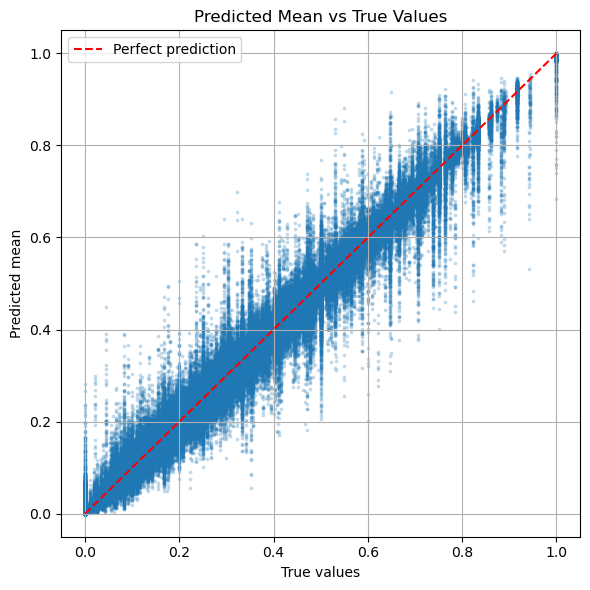

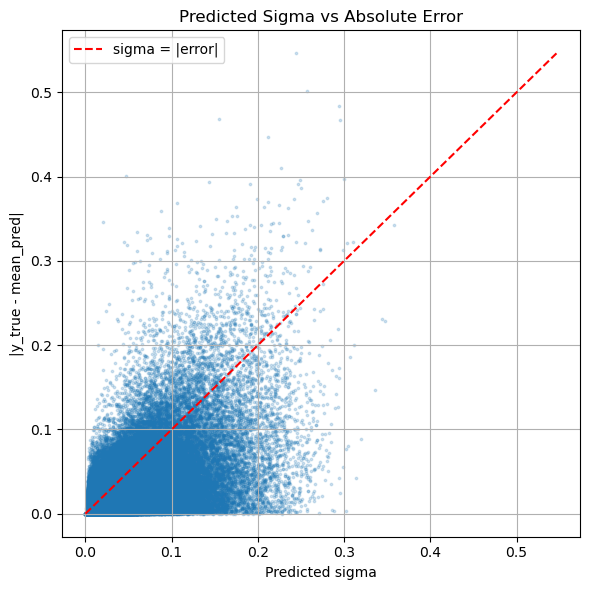

In [151]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Step 1 — 提取 mean, sigma, truth
# ------------------------------


# model_samples: (412, 20, 12, 275)
# 在 sample 维度(axis=1)计算标准差
y_pred_sigma = np.std(model_samples, axis=1)  # -> (412, 12, 275)

# ground_truths: (412, 12, 275)
y_true = ground_truths

# ------------------------------
# Step 2 — reshape 成一维
# ------------------------------
y_pred_mean_flat  = y_pred_mean.reshape(-1)
y_pred_sigma_flat = y_pred_sigma.reshape(-1)
y_true_flat       = y_true.reshape(-1)

print("Flattened size:", len(y_true_flat))


# ------------------------------
# 绘图函数 1：mean vs true
# ------------------------------
def plot_mean_vs_true(y_true, y_pred_mean):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred_mean, alpha=0.2, s=3)
    min_val = min(y_true.min(), y_pred_mean.min())
    max_val = max(y_true.max(), y_pred_mean.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')

    plt.xlabel("True values")
    plt.ylabel("Predicted mean")
    plt.title("Predicted Mean vs True Values")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ------------------------------
# 绘图函数 2：sigma vs |error|
# ------------------------------
def plot_sigma_vs_error(y_true, y_pred_mean, y_pred_sigma):
    abs_error = np.abs(y_true - y_pred_mean)

    plt.figure(figsize=(6, 6))
    plt.scatter(y_pred_sigma, abs_error, alpha=0.2, s=3)
    plt.xlabel("Predicted sigma")
    plt.ylabel("|y_true - mean_pred|")
    plt.title("Predicted Sigma vs Absolute Error")
    plt.grid(True)

    max_val = max(y_pred_sigma.max(), abs_error.max())
    plt.plot([0, max_val], [0, max_val], 'r--', label='sigma = |error|')
    plt.legend()

    plt.tight_layout()
    plt.show()


# ------------------------------
# Step 3 — 绘图
# ------------------------------
plot_mean_vs_true(y_true_flat, y_pred_mean_flat)
plot_sigma_vs_error(y_true_flat, model_predictions.reshape(-1), y_pred_sigma_flat)


In [152]:
y_pred_sigma_flat.max()

0.35783005

In [153]:
abs_error = np.abs(y_true.reshape(-1) - model_predictions.reshape(-1))

In [154]:
abs_error.mean()

0.007466011

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore

# =============================
# 输入数据（替换为你的预测）
# =============================
# y_true:       shape (N,)
# y_pred_mean:  shape (N,)
# y_pred_quantiles: shape (N, Q)
# quantile_levels: shape (Q,)

# y_true = ...
# y_pred_mean = ...
# y_pred_quantiles = ...
# quantile_levels = ...

# ===============================================================
# 1. 诊断 A：系统性低估真实值 (Mean Bias)
# ===============================================================
def diagnose_mean_bias(y_true, y_pred_mean):
    bias = np.mean(y_pred_mean - y_true)
    print("🧪 Mean Bias (预测 - 真实):", bias)

    if bias < 0:
        print("⚠️  模型系统性低估真实值（预测均值偏小）")
    elif bias > 0:
        print("⚠️  模型系统性高估真实值（预测均值偏大）")
    else:
        print("✔ 无明显均值偏差")

# ===============================================================
# 2. 诊断 B：覆盖率（Coverage）
# ===============================================================
def diagnose_coverage(y_true, y_pred_quantiles, quantiles):
    print("\n🧪 Coverage 检查：")
    for i, q in enumerate(quantiles):
        coverage = np.mean(y_true <= y_pred_quantiles[:, i])
        print(f"  q={q:.2f}:  模型覆盖率={coverage:.3f}")

    print("\n⚠️ 若所有 coverage < quantiles → 预测分布过窄（Under-dispersion）")
    print("⚠️ 若所有 coverage > quantiles → 预测分布过宽（Over-dispersion）")

# ===============================================================
# 3. 诊断 C：分位数误差：模型 quantile vs 真实 quantile
# ===============================================================
def diagnose_quantile_shift(y_true, y_pred_quantiles, quantiles):
    print("\n🧪 分位数偏移检查（真实分位对齐 vs 模型预测）：")

    true_sorted = np.sort(y_true)
    N = len(y_true)

    for i, q in enumerate(quantiles):
        true_q = true_sorted[int(q * (N - 1))]
        pred_q = np.mean(y_pred_quantiles[:, i])

        print(f"  q={q:.2f}: 真实分位={true_q:.3f}, 预测分位={pred_q:.3f}, 差={pred_q-true_q:.3f}")

# ===============================================================
# 4. 诊断 D：PIT Histogram（检验分布宽度/偏移）
# ===============================================================
def diagnose_pit(y_true, y_pred_quantiles, quantiles):
    pits = np.zeros_like(y_true, dtype=np.float32)
    for i in range(len(y_true)):
        pits[i] = percentileofscore(y_pred_quantiles[i], y_true[i]) / 100.0

    plt.figure(figsize=(6,4))
    plt.hist(pits, bins=20, density=True, alpha=0.7)
    plt.axhline(1.0, color="red", linestyle="--")
    plt.title("PIT Histogram")
    plt.show()

    # 自动判断
    hist, _ = np.histogram(pits, bins=10)
    left = hist[:3].sum()
    right = hist[-3:].sum()
    mid = hist[4:6].sum()

    if left > mid and right > mid:
        print("⚠️ U 型 → Under-dispersion（预测分布太窄）")
    elif mid > left and mid > right:
        print("⚠️ ∧ 型 → Over-dispersion（预测分布太宽）")
    elif np.mean(pits) < 0.45:
        print("⚠️ 全体左偏 → 模型预测均值偏大（系统性高估）")
    elif np.mean(pits) > 0.55:
        print("⚠️ 全体右偏 → 模型预测均值偏小（系统性低估）")
    else:
        print("✔ PIT 分布合理")

# ===============================================================
# 5. 诊断 E：Reliability Diagram
# ===============================================================
def reliability_diagram(y_true, y_pred_quantiles, quantiles):
    obs = []
    for i, q in enumerate(quantiles):
        obs.append(np.mean(y_true <= y_pred_quantiles[:, i]))

    plt.figure(figsize=(6,6))
    plt.plot([0,1], [0,1], "--", color="red", label="perfect reliability")
    plt.plot(quantiles, obs, "o-", color="blue", label="model")
    plt.xlabel("Predicted Quantiles")
    plt.ylabel("Observed Frequencies")
    plt.title("Reliability Diagram")
    plt.legend()
    plt.grid()
    plt.show()

    # 自动判断
    if all(o < q for o, q in zip(obs, quantiles)):
        print("⚠️ Reliability 曲线整体在下方 → 模型分布过窄 + 系统性低估真实值")
    elif all(o > q for o, q in zip(obs, quantiles)):
        print("⚠️ Reliability 曲线整体在上方 → 模型分布过宽 + 系统性高估真实值")
    else:
        print("✔ Reliability 正常")

# ===============================================================
# ⛳ 一键运行所有诊断
# ===============================================================
def run_all_diagnosis(y_true, y_pred_mean, y_pred_quantiles, quantiles):
    print("=============== 🧠 Calibration Diagnostic Report ===============")
    diagnose_mean_bias(y_true, y_pred_mean)
    diagnose_coverage(y_true, y_pred_quantiles, quantiles)
    diagnose_quantile_shift(y_true, y_pred_quantiles, quantiles)
    diagnose_pit(y_true, y_pred_quantiles, quantiles)
    reliability_diagram(y_true, y_pred_quantiles, quantiles)
    print("============================== END ==============================")

# 示例调用：
# run_all_diagnosis(y_true, y_pred_mean, y_pred_quantiles, quantile_levels)


(412, 12, 275, 10)
=============== 🧠 Calibration Diagnostic Report ===============
🧪 Mean Bias (预测 - 真实): -0.0015568702
⚠️  模型系统性低估真实值（预测均值偏小）

🧪 Coverage 检查：
  q=0.10:  模型覆盖率=0.063
  q=0.20:  模型覆盖率=0.108
  q=0.30:  模型覆盖率=0.166
  q=0.40:  模型覆盖率=0.244
  q=0.50:  模型覆盖率=0.345
  q=0.60:  模型覆盖率=0.472
  q=0.70:  模型覆盖率=0.618
  q=0.80:  模型覆盖率=0.763
  q=0.90:  模型覆盖率=0.884
  q=1.00:  模型覆盖率=0.969

⚠️ 若所有 coverage < quantiles → 预测分布过窄（Under-dispersion）
⚠️ 若所有 coverage > quantiles → 预测分布过宽（Over-dispersion）

🧪 分位数偏移检查（真实分位对齐 vs 模型预测）：
  q=0.10: 真实分位=0.060, 预测分位=0.218, 差=0.158
  q=0.20: 真实分位=0.100, 预测分位=0.223, 差=0.123
  q=0.30: 真实分位=0.136, 预测分位=0.227, 差=0.091
  q=0.40: 真实分位=0.168, 预测分位=0.230, 差=0.062
  q=0.50: 真实分位=0.202, 预测分位=0.233, 差=0.031
  q=0.60: 真实分位=0.235, 预测分位=0.236, 差=0.001
  q=0.70: 真实分位=0.278, 预测分位=0.239, 差=-0.038
  q=0.80: 真实分位=0.336, 预测分位=0.243, 差=-0.093
  q=0.90: 真实分位=0.458, 预测分位=0.249, 差=-0.209
  q=1.00: 真实分位=1.000, 预测分位=0.264, 差=-0.736


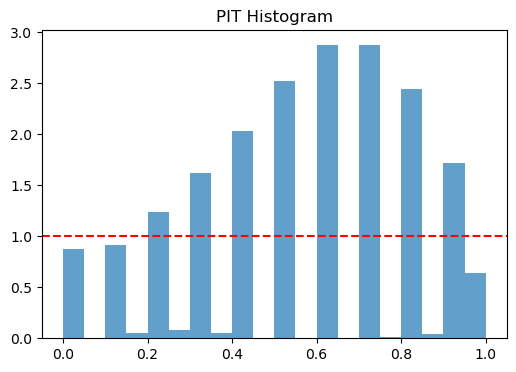

✔ PIT 分布合理


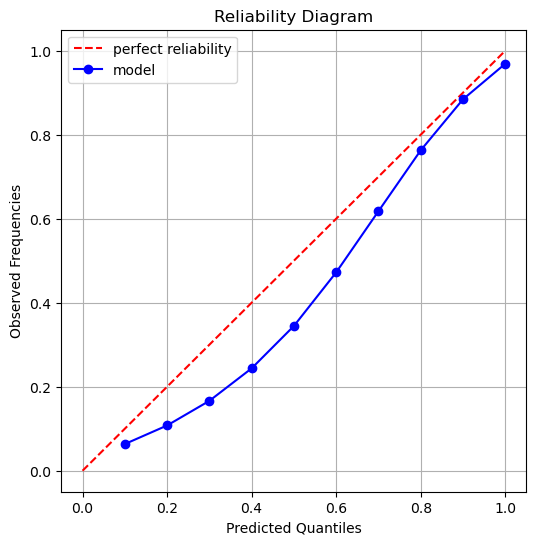

⚠️ Reliability 曲线整体在下方 → 模型分布过窄 + 系统性低估真实值
============================== END ==============================


In [156]:
import numpy as np

# model_samples: (412, 20, 12, 275)
# ground_truths: (412, 12, 275)

quantile_levels = np.array([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])

# 计算各分位数
# 输出 shape: (412, 12, 275, Q)
pred_quantiles = np.quantile(model_samples, quantile_levels, axis=1)  
pred_quantiles = np.moveaxis(pred_quantiles, 0, -1)  
# 现在 pred_quantiles shape = (412, 12, 275, Q)

print(pred_quantiles.shape)
# ground_truths: (412, 12, 275)
y_true = ground_truths.reshape(-1)   # shape = (412*12*275,)

# pred quantiles: (412, 12, 275, Q)
y_pred_quantiles = pred_quantiles.reshape(-1, len(quantile_levels))
y_pred_mean = np.mean(model_samples, axis=1)   # (412, 12, 275)
y_pred_mean = y_pred_mean.reshape(-1)
run_all_diagnosis(
    y_true,
    y_pred_mean,
    y_pred_quantiles,
    quantile_levels
)
